In [ ]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf
import unicodedata

from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Recurrence-based Seq2Seq Neural Machine Translation Without Attention

Model kami hanya menggunakan dua LSTM (satu encoder dan satu decoder) untuk menerjemahkan

Dataset yang akan kita gunakan berasal dari file .srt.

In [ ]:
# Upload the training set.

files.upload()


Saving frzendatbase(3)_train.txt to frzendatbase(3)_train.txt


{'frzendatbase(3)_train.txt': b"\xef\xbb\xbfLahir dari udara dingin dan musim dingin<sep>Born of cold and winter air\r\nDan kombinasi hujan gunung<sep>And mountain rain combining\r\nKekuatan es ini busuk dan adil<sep>This icy force both foul and fair\r\nMemiliki hati beku yang layak ditambang<sep>Has a frozen heart worth mining\r\nJadi potong hati<sep>So cut through the heart\r\nDingin dan jernih<sep>Cold and clear\r\nSerang karena cinta dan serang karena takut<sep>Strike for love and strike for fear\r\nLihat keindahannya tajam dan tipis<sep>See the beauty sharp and sheer\r\nPisahkan es<sep>Split the ice apart\r\nDan patahkan hati yang beku Hup, ho<sep>And break the frozen heart Hup, ho\r\nPerhatikan langkahmu Lepaskan<sep>Watch your step Let it go\r\nHah, ah<sep>Hup, ho\r\nPerhatikan langkahmu Lepaskan<sep>Watch your step Let it go\r\nCantik Berdaya<sep>Beautiful Powerful\r\nDingin yang Berbahaya<sep>Dangerous Cold\r\nEs memiliki sihir Tidak bisa dikendalikan<sep>Ice has a magic Can't

In [ ]:
with open('frzendatbase(3)_train.txt', encoding='utf-8-sig') as file:
  train = [line.rstrip() for line in file]


Setiap entri terdiri dari kalimat subtittle Indonesia diikuti dengan translasi bahasa Inggrisnya, dipisahkan oleh pembatas (sep)

In [ ]:
train[:3]

['Lahir dari udara dingin dan musim dingin<sep>Born of cold and winter air',
 'Dan kombinasi hujan gunung<sep>And mountain rain combining',
 'Kekuatan es ini busuk dan adil<sep>This icy force both foul and fair']

In [ ]:
len(train)

1649

In [ ]:
SEPARATOR = '<sep>'
train_input, train_target = map(list, zip(*[pair.split(SEPARATOR) for pair in train]))

In [ ]:
print(train_input[:3])
print(train_target[:3])

['Lahir dari udara dingin dan musim dingin', 'Dan kombinasi hujan gunung', 'Kekuatan es ini busuk dan adil']
['Born of cold and winter air', 'And mountain rain combining', 'This icy force both foul and fair']


Penerapan normalisasi Unicode

In [ ]:
print("\u00E1", "\u0061\u0301")

á á


In [ ]:
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

Fungsi ini akan menampilkan tanda baca sebagai token terpisah dan normalisasi unicode.

In [ ]:
def preprocess_sentence(s):
  s = normalize_unicode(s)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

In [ ]:
train_preprocessed_input = [preprocess_sentence(s) for s in train_input]
train_preprocessed_target = [preprocess_sentence(s) for s in train_target]

Setelah preprocessing, unicode harus dinormalisasi dan harus ada spasi di kedua sisi tanda baca.

In [ ]:
train_preprocessed_input[:3]

['Lahir dari udara dingin dan musim dingin',
 'Dan kombinasi hujan gunung',
 'Kekuatan es ini busuk dan adil']

Menggunakan Teacher Forcing yang menempatkan tag awal kalimat (sos) dan tag akhir kalimat (eos) masing-masing di awal dan akhir setiap kalimat target.

In [ ]:
def tag_target_sentences(sentences):
  tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
  return list(tagged_sentences)

In [ ]:
train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

In [ ]:
train_tagged_preprocessed_target[:3]

['<sos> Born of cold and winter air <eos>',
 '<sos> And mountain rain combining <eos>',
 '<sos> This icy force both foul and fair <eos>']

Tokenize kalimat input dan target.

Menyertakan token out-of-vocabulary (oov) dalam inisialisasi tokenizer.

Pada waktu inferensi, jika tokenizer menemukan kata yang tidak dilihatnya selama penyesuaian awal pada training data, kata tersebut akan diganti dengan (oov) dan sistem terjemahan harus mengatasinya.

In [ ]:
source_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_preprocessed_input)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<oov>',
 'document_count': 1649,
 'word_counts': '{"lahir": 3, "dari": 41, "udara": 4, "dingin": 30, "dan": 130, "musim": 33, "kombinasi": 2, "hujan": 2, "gunung": 13, "kekuatan": 6, "es": 23, "ini": 91, "busuk": 2, "adil": 3, "memiliki": 15, "hati": 19, "beku": 10, "yang": 156, "layak": 3, "ditambang": 2, "jadi": 28, "potong": 2, "jernih": 2, "serang": 4, "karena": 27, "cinta": 52, "takut": 8, "lihat": 12, "keindahannya": 1, "tajam": 2, "tipis": 2, "pisahkan": 2, "patahkan": 1, "hup": 1, ",": 425, "ho": 2, "perhatikan": 4, "langkahmu": 3, "lepaskan": 15, "hah": 5, "ah": 11, "cantik": 10, "berdaya": 1, "berbahaya": 5, "sihir": 7, "tidak": 283, "bisa": 59, "dikendalikan": 1, "lebih": 29, "kuat": 8, "satu": 15, "sepuluh": 3, "seratus": 1, "orang": 29, "!": 367, "om": 1, "melalui": 3, "ada": 37, "keindahan": 2, "bahaya": 4, "di": 96, "sini": 40, "dengan": 4

In [ ]:
source_vocab_size = len(source_tokenizer.word_index) + 1
print(source_vocab_size)

1364


In [ ]:
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<oov>',
 'document_count': 1649,
 'word_counts': '{"<sos>": 1649, "born": 6, "of": 85, "cold": 18, "and": 133, "winter": 13, "air": 4, "<eos>": 1649, "mountain": 11, "rain": 2, "combining": 2, "this": 67, "icy": 3, "force": 3, "both": 12, "foul": 2, "fair": 3, "has": 15, "a": 141, "frozen": 11, "heart": 16, "worth": 3, "mining": 2, "so": 49, "cut": 2, "through": 9, "the": 205, "clear": 2, "strike": 4, "for": 55, "love": 57, "fear": 7, "see": 27, "beauty": 3, "sharp": 2, "sheer": 1, "split": 2, "ice": 22, "apart": 2, "break": 3, "hup": 2, ",": 507, "ho": 3, "watch": 7, "your": 54, "step": 3, "let": 37, "it": 116, "go": 67, "beautiful": 10, "powerful": 2, "dangerous": 4, "magic": 8, "can\'t": 24, "be": 72, "controlled": 2, "stronger": 5, "than": 7, "one": 19, "ten": 3, "hundred": 1, "men": 3, "!": 367, "om": 1, "there\'s": 6, "danger": 5, "here": 45, "bewa

In [ ]:
target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

1281


Vectorize kalimat input dan target.

In [ ]:
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_preprocessed_input)

In [ ]:
print(train_encoder_inputs[:3])
print(source_tokenizer.sequences_to_texts(train_encoder_inputs[:3]))

[[329, 37, 277, 48, 11, 45, 48], [11, 427, 428, 108], [200, 60, 16, 429, 11, 330]]
['lahir dari udara dingin dan musim dingin', 'dan kombinasi hujan gunung', 'kekuatan es ini busuk dan adil']


Fungsi di bawah mengambil kumpulan kalimat, memvektorisasi, lalu menjadikan masing-masing dua salinan. Yang pertama akan menyertakan setiap token kecuali yang terakhir. Yang kedua akan menyertakan setiap token kecuali yang pertama.

In [ ]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs]
  decoder_targets = [s[1:] for s in seqs]

  return decoder_inputs, decoder_targets

In [ ]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target,
                                                                              target_tokenizer)

In [ ]:
print(train_decoder_inputs[0], train_decoder_targets[0])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]),
      target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[2, 231, 18, 93, 13, 121, 301] [231, 18, 93, 13, 121, 301, 3]
['<sos> born of cold and winter air'] ['born of cold and winter air <eos>']


Mengisi semua urutan dengan panjang yang seragam.

In [ ]:
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

19

In [ ]:
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

19

In [ ]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [ ]:
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[329  37 277  48  11  45  48   0   0   0   0   0   0   0   0   0   0   0
   0]
[  2 231  18  93  13 121 301   0   0   0   0   0   0   0   0   0   0   0
   0]
[231  18  93  13 121 301   3   0   0   0   0   0   0   0   0   0   0   0
   0]


In [ ]:
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

['<sos> born of cold and winter air <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov>']

Menyiapkan dataset validasi.

In [ ]:
# Upload validation set pairs.

files.upload()

Saving frzendatbase(3)_val.txt to frzendatbase(3)_val.txt


{'frzendatbase(3)_val.txt': b"\xef\xbb\xbfLahir dari udara dingin dan musim dingin<sep>Born of cold and winter air\r\nDan kombinasi hujan gunung<sep>And mountain rain combining\r\nKekuatan es ini busuk dan adil<sep>This icy force both foul and fair\r\nMemiliki hati beku yang layak ditambang<sep>Has a frozen heart worth mining\r\nJadi potong hati<sep>So cut through the heart\r\nDingin dan jernih<sep>Cold and clear\r\nSerang karena cinta dan serang karena takut<sep>Strike for love and strike for fear\r\nLihat keindahannya tajam dan tipis<sep>See the beauty sharp and sheer\r\nPisahkan es<sep>Split the ice apart\r\nDan patahkan hati yang beku Hup, ho<sep>And break the frozen heart Hup, ho\r\nPerhatikan langkahmu Lepaskan<sep>Watch your step Let it go\r\nHah, ah<sep>Hup, ho\r\nPerhatikan langkahmu Lepaskan<sep>Watch your step Let it go\r\nCantik Berdaya<sep>Beautiful Powerful\r\nDingin yang Berbahaya<sep>Dangerous Cold\r\nEs memiliki sihir Tidak bisa dikendalikan<sep>Ice has a magic Can't b

In [ ]:
with open('frzendatbase(3)_val.txt', encoding='utf-8-sig') as file:
  val = [line.rstrip() for line in file]



In [ ]:
def process_dataset(dataset):
  input, output = map(list, zip(*[pair.split(SEPARATOR) for pair in dataset]))

  preprocessed_input = [preprocess_sentence(s) for s in input]
  preprocessed_output = [preprocess_sentence(s) for s in output]

  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [ ]:
# validation dataset
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val)

Membangun model.

In [ ]:
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 8
epochs = 30

Encoder menerima kalimat sumber (Bahasa Indonesia) dan menghasilkan initial state input untuk dekoder.
Decoder menerima kalimat input decoder (Bahasa Inggris) untuk teacher forcing.

In [ ]:
encoder_inputs = layers.Input(shape=[None], name='encoder_inputs')

encoder_embeddings = layers.Embedding(source_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='encoder_embeddings')

encoder_embedding_output = encoder_embeddings(encoder_inputs)

encoder_lstm = layers.LSTM(hidden_dim,
                           return_state=True,
                           dropout=default_dropout,
                           name='encoder_lstm')

encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)

encoder_states = (state_h, state_c)

In [ ]:
decoder_inputs = layers.Input(shape=[None], name='decoder_inputs')

decoder_embeddings = layers.Embedding(target_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='decoder_embeddings')

decoder_embedding_output = decoder_embeddings(decoder_inputs)

decoder_lstm = layers.LSTM(hidden_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=default_dropout,
                           name='decoder_lstm')

decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

y_proba = decoder_dense(decoder_outputs)

Membuat model dan membangunnya memiliki dua input dan satu output. Dengan menggunakan performance metric, BLEU.

In [ ]:
model = tf.keras.Model([encoder_inputs, decoder_inputs], y_proba, name='hun_eng_seq2seq_nmt_no_attention')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics='sparse_categorical_accuracy')
model.summary()

Model: "hun_eng_seq2seq_nmt_no_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embeddings (Embedding)  (None, None, 128)   174592      ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embeddings (Embedding)  (None, None, 128)   163968      ['decoder_inputs[0][0]']         
                                                                   

Visualisasi model.

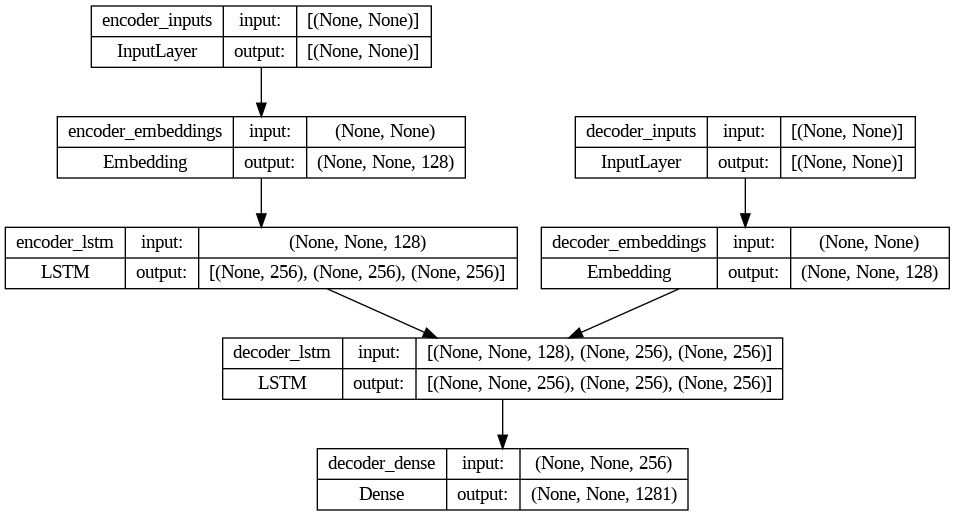

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='hun_eng_seq2seq_nmt_no_attention.png', show_shapes=True, show_layer_names=True)

Matrix dimensions

In [ ]:
print('encoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len)))
print()
print('encoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len, embedding_dim)))
print()
print('encoder_lstm layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len, embedding_dim), [(batch_size, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print()
print('decoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len)))
print()
print('decoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len, embedding_dim)))
print()
print('decoder_lstm layer\n input dimension {}\n output dimension: {}'.format([(batch_size, max_decoding_len, embedding_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)], [(batch_size, max_decoding_len, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print('decoder_dense layer(softmax)\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len, hidden_dim), (batch_size, max_decoding_len, target_vocab_size)))

encoder_inputs layer
 input dimension (8, 19)
 output dimension: (8, 19)

encoder_embeddings layer
 input dimension (8, 19)
 output dimension: (8, 19, 128)

encoder_lstm layer
 input dimension (8, 19, 128)
 output dimension: [(8, 256), (8, 256), (8, 256)]


decoder_inputs layer
 input dimension (8, 19)
 output dimension: (8, 19)

decoder_embeddings layer
 input dimension (8, 19)
 output dimension: (8, 19, 128)

decoder_lstm layer
 input dimension [(8, 19, 128), (8, 256), (8, 256)]
 output dimension: [(8, 19, 256), (8, 256), (8, 256)]

decoder_dense layer(softmax)
 input dimension (8, 19, 256)
 output dimension: (8, 19, 1281)


Model checkpoints

In [ ]:
filepath= r"E:\UB\Tahun Ketiga\Semester 6\Google BANGKIT Academy 2023\CAPSTONE\Dataset\FINAL OUTPUT\Frozen"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

Early stopping & Fit method

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0.3)
history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
                      callbacks=[cp_callback, es_callback])

Epoch 1/30
207/207 [==============================] - ETA: 0s - loss: 4.5733 - sparse_categorical_accuracy: 0.2168

Exception ignored in: <function _xla_gc_callback at 0x7f7f3b93d120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 



Epoch 1: saving model to E:\UB\Tahun Ketiga\Semester 6\Google BANGKIT Academy 2023\CAPSTONE\Dataset\FINAL OUTPUT\Frozen
207/207 [==============================] - 94s 454ms/step - loss: 4.5733 - sparse_categorical_accuracy: 0.2168 - val_loss: 4.2879 - val_sparse_categorical_accuracy: 0.2339
Epoch 2/30
207/207 [==============================] - ETA: 0s - loss: 4.2575 - sparse_categorical_accuracy: 0.2466
Epoch 2: saving model to E:\UB\Tahun Ketiga\Semester 6\Google BANGKIT Academy 2023\CAPSTONE\Dataset\FINAL OUTPUT\Frozen
207/207 [==============================] - 39s 189ms/step - loss: 4.2575 - sparse_categorical_accuracy: 0.2466 - val_loss: 3.9729 - val_sparse_categorical_accuracy: 0.2795
Epoch 3/30
207/207 [==============================] - ETA: 0s - loss: 3.9455 - sparse_categorical_accuracy: 0.3005
Epoch 3: saving model to E:\UB\Tahun Ketiga\Semester 6\Google BANGKIT Academy 2023\CAPSTONE\Dataset\FINAL OUTPUT\Frozen
207/207 [==============================] - 39s 188ms/step - loss:

Menyimpan model dan Tokenizer.

In [ ]:
import zipfile

model.save('frzendatbase_hasil_akhir')

!zip -r ./frzendatbase_hasil_akhir.zip ./frzendatbase_hasil_akhir
files.download("./frzendatbase_hasil_akhir.zip")

source_tokenizer_json = source_tokenizer.to_json()
with io.open('source_tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(source_tokenizer_json, ensure_ascii=False))

target_tokenizer_json = target_tokenizer.to_json()
with io.open('target_tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(target_tokenizer_json, ensure_ascii=False))

updating: frzendatbase_hasil_akhir/ (stored 0%)
updating: frzendatbase_hasil_akhir/keras_metadata.pb (deflated 91%)
updating: frzendatbase_hasil_akhir/saved_model.pb (deflated 90%)
updating: frzendatbase_hasil_akhir/fingerprint.pb (stored 0%)
updating: frzendatbase_hasil_akhir/assets/ (stored 0%)
updating: frzendatbase_hasil_akhir/variables/ (stored 0%)
updating: frzendatbase_hasil_akhir/variables/variables.data-00000-of-00001 (deflated 6%)
updating: frzendatbase_hasil_akhir/variables/variables.index (deflated 63%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mengambil model yang disimpan dan tokenizer yang disimpan dan mencobanya pada test data set.

In [ ]:
# Retrieve the tokenizers.

files.upload()

Saving frzendatbase_hasil_akhir_tokenizer.zip to frzendatbase_hasil_akhir_tokenizer.zip


{'frzendatbase_hasil_akhir_tokenizer.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00\x82\x0e\xcfV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00#\x00\x00\x00frzendatbase_hasil_akhir_tokenizer/PK\x03\x04\x14\x00\x00\x00\x08\x00l\x0e\xcfV\x19*\'S\x88y\x00\x00^D\x02\x008\x00\x00\x00frzendatbase_hasil_akhir_tokenizer/source_tokenizer.jsont\\\xd9\x96\xe5\xb6n\xfd\x15\xa73\xdc\x0c7\x89\xab\xaaGg\xfc\x88\xbc\xa5\x92\x0eu\xc4\x92x4.\x89t\xe5\xd8I\xbe=\x00ER\xc4\x86\xfa\xc1k\xb9\xd8\x12E\x82\xc0\xc6\xc6\xc0\xf3\xe1\xf7\xd7\x0f\xb7\xd1\xec\xfb\xf7\xd9L\xf6\xf5\xc3/?\xbd~\xf8\xb7e\xb0\xb3\xfb\xcdn\xaf\x1f\xfeH\x7f\xde\x96\xf9\xcdu\xfcO\xf4\xec\x1c\xa6\xef\xef\xcb\xd6\xee\xfc\xf7\x1c\xc6\x91\x9fxs\xa3\xb7\xdb~\xbc\xfd\xfa\xfa\xfa\xe1O\xff\xec\xcf\xff\xe2/\xff\xea\xaf\xff\xe6o\xff\xfe\x97\x7f\xf8\xa7\x7f\xfdw\x1az\xfd\x8f\xff\xfc\xfe_\xbf\xff\xcf\xff\xfe\xdf\xeb\xab\x7f}\x9d\x8f\x99\xc7\xe5\x9d?\xf2\xcbO~\x0b\x96\x07\xf6ut\xfe\x98\xe6\xa7\xf4\xf1\xdel\xdfG\xfb\xab\x1dy\xf8\xcd\x8c{|pY~\xfd\xeey\x99\xc7\x

In [ ]:
!unzip -o frzendatbase_hasil_akhir_tokenizer.zip

Archive:  frzendatbase_hasil_akhir_tokenizer.zip
   creating: frzendatbase_hasil_akhir_tokenizer/
  inflating: frzendatbase_hasil_akhir_tokenizer/source_tokenizer.json  
  inflating: frzendatbase_hasil_akhir_tokenizer/target_tokenizer.json  


Memuat tokenizer dengan metode tokenizer_from_json.

In [ ]:
with open('source_tokenizer.json') as f:
    data = json.load(f)
    source_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open('target_tokenizer.json') as f:
    data = json.load(f)
    target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [ ]:
# Retrieve the model.

files.upload()

Saving frzendatbase_hasil_akhir.zip to frzendatbase_hasil_akhir (1).zip


In [ ]:
!unzip -o frzendatbase_hasil_akhir.zip

Archive:  frzendatbase_hasil_akhir.zip
  inflating: frzendatbase_hasil_akhir/keras_metadata.pb  
  inflating: frzendatbase_hasil_akhir/saved_model.pb  
 extracting: frzendatbase_hasil_akhir/fingerprint.pb  
  inflating: frzendatbase_hasil_akhir/variables/variables.data-00000-of-00001  
  inflating: frzendatbase_hasil_akhir/variables/variables.index  


In [ ]:
# Load the model.
model = tf.keras.models.load_model('frzendatbase_hasil_akhir')

In [ ]:
# Retrieve the test dataset.

files.upload()

Saving frzendatbase(3)_test.txt to frzendatbase(3)_test.txt


{'frzendatbase(3)_test.txt': b"\xef\xbb\xbfLahir dari udara dingin dan musim dingin<sep>Born of cold and winter air\r\nDan kombinasi hujan gunung<sep>And mountain rain combining\r\nKekuatan es ini busuk dan adil<sep>This icy force both foul and fair\r\nMemiliki hati beku yang layak ditambang<sep>Has a frozen heart worth mining\r\nJadi potong hati<sep>So cut through the heart\r\nDingin dan jernih<sep>Cold and clear\r\nSerang karena cinta dan serang karena takut<sep>Strike for love and strike for fear\r\nLihat keindahannya tajam dan tipis<sep>See the beauty sharp and sheer\r\nPisahkan es<sep>Split the ice apart\r\nDan patahkan hati yang beku Hup, ho<sep>And break the frozen heart Hup, ho\r\nPerhatikan langkahmu Lepaskan<sep>Watch your step Let it go\r\nHah, ah<sep>Hup, ho\r\nPerhatikan langkahmu Lepaskan<sep>Watch your step Let it go\r\nCantik Berdaya<sep>Beautiful Powerful\r\nDingin yang Berbahaya<sep>Dangerous Cold\r\nEs memiliki sihir Tidak bisa dikendalikan<sep>Ice has a magic Can't 

In [ ]:
with open('frzendatbase(3)_test.txt',  encoding='utf-8-sig') as file:
  test = [line.rstrip() for line in file]

In [ ]:
test[:3]

['Lahir dari udara dingin dan musim dingin<sep>Born of cold and winter air',
 'Dan kombinasi hujan gunung<sep>And mountain rain combining',
 'Kekuatan es ini busuk dan adil<sep>This icy force both foul and fair']

In [ ]:
# test dataset
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(test)

In [ ]:
model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

52/52 [==============================] - 7s 71ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9955


[0.08752616494894028, 0.9955279231071472]

Training model untuk kasus inference, dengan membuat stand-alone model encoder dan decoder terpisah.

In [ ]:
[layer.name for layer in model.layers]

['encoder_inputs',
 'decoder_inputs',
 'encoder_embeddings',
 'decoder_embeddings',
 'encoder_lstm',
 'decoder_lstm',
 'decoder_dense']

Membuat stand-alone encoder.

In [ ]:
encoder_inputs = model.get_layer('encoder_inputs').input

encoder_embedding_layer = model.get_layer('encoder_embeddings')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('encoder_lstm')

_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)

encoder_states = [encoder_state_h, encoder_state_c]

encoder_model_no_attention = tf.keras.Model(encoder_inputs, encoder_states)

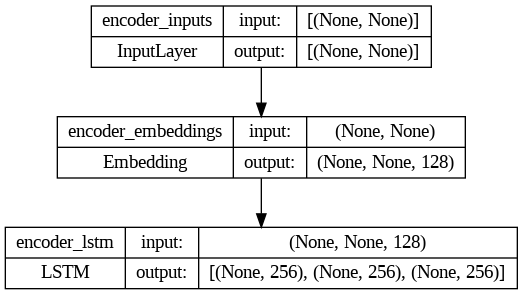

In [ ]:
plot_model(encoder_model_no_attention, to_file='encoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

Membuat stand-alone decoder, dengan dua input tambahan ke dekoder yaitu LSTM hidden state (decoder_input_state_h) dan cell state (decoder_input_state_c).

Stand-alone decoder sekarang mengambil sebagai input:
Token (sos) / output dari timestep sebelumnya. Hidden state dan cell state.

Menghasilkan distribusi probabilitas untuk output saat ini, dan hidden state dan cell state baru.


In [ ]:
decoder_inputs = model.get_layer('decoder_inputs').input

decoder_embedding_layer = model.get_layer('decoder_embeddings')
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_input_state_c = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_c')
decoder_input_states = [decoder_input_state_h, decoder_input_state_c]

decoder_lstm = model.get_layer('decoder_lstm')

decoder_sequence_outputs, decoder_output_state_h, decoder_output_state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_input_states
)

decoder_output_states = [decoder_output_state_h, decoder_output_state_c]

decoder_dense = model.get_layer('decoder_dense')
y_proba = decoder_dense(decoder_sequence_outputs)

decoder_model_no_attention = tf.keras.Model(
    [decoder_inputs] + decoder_input_states,
    [y_proba] + decoder_output_states
)

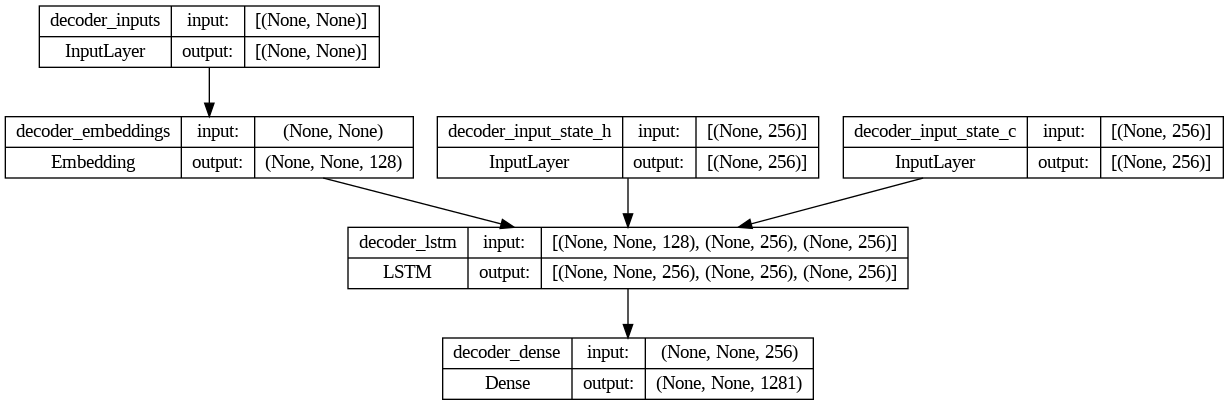

In [ ]:
plot_model(decoder_model_no_attention, to_file='decoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

Metode menerjemahkan kalimat dari bahasa source ke bahasa target. Kata yang dihasilkan output dekoder dan hidden state dan cell state nya kemudian diberikan lagi ke dekoder hingga token (eos) dihasilkan.

In [ ]:
def translate_without_attention(sentence: str,
                                source_tokenizer, encoder,
                                target_tokenizer, decoder,
                                max_translated_len = 30):

  input_seq = source_tokenizer.texts_to_sequences([sentence])

  tokenized_sentence = source_tokenizer.sequences_to_texts(input_seq)

  states = encoder.predict(input_seq)

  current_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < max_translated_len:

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_tokenizer.word_index[current_word]

    target_y_proba, h, c = decoder.predict([target_seq] + states)
    target_token_index = np.argmax(target_y_proba[0, -1, :])
    current_word = target_tokenizer.index_word[target_token_index]

    if (current_word == '<eos>'):
      break

    decoded_sentence.append(current_word)
    states = [h, c]

  return tokenized_sentence[0], ' '.join(decoded_sentence)

Pengujian dengan mengambil sampel kalimat-kalimat dari test dataset.

In [ ]:
random.seed(1)
sentences = random.sample(test, 1649)
sentences

['memukul putri Arendelle dengan kuda saya.<sep>for hitting the princess of Arendelle with my horse.',
 'Oke!  Kemana kita akan pergi?<sep>Okay! Where are we going?',
 "Saya mengerti, saya mengerti.  Saya tidak mengerti, saya tidak mengerti.<sep>I got it, I got it. I don't got it, I don't got it.",
 'TIDAK.<sep>No.',
 "Itu semakin kuat!<sep>It's getting stronger!",
 'Tidak ada jejak yang terlihat<sep>Not a footprint to be seen',
 'Jadilah gadis yang baik<sep>Be the good girl',
 "Anda tidak harus melindungi saya. Saya tidak takut.<sep>You don't have to protect me. I'm not afraid.",
 'Dia berkata bahwa kamu membekukan hatinya.<sep>She said that you froze her heart.',
 'Apa sekarang?<sep>What now?',
 'dia membekukan segalanya.<sep>she froze everything.',
 'Tapi Anda bisa menghapusnya, bukan?<sep>But you can remove it, right?',
 'Anda tahu, bagaimana dengan sedikit warna?<sep>You know, how about a little color?',
 "Dan itu adalah model terbaru.<sep>And it's the latest model.",
 'Pernikahan

In [ ]:
def translate_sentences(sentences, translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for s in sentences:
    source, target = s.split(SEPARATOR)
    source = preprocess_sentence(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

Memuat hasil ke dalam Pandas DataFrame.

In [ ]:
translations_no_attention = pd.DataFrame(translate_sentences(sentences, translate_without_attention,
                                                             source_tokenizer, encoder_model_no_attention,
                                                             target_tokenizer, decoder_model_no_attention))
translations_no_attention

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step


,Tokenized Original,Reference,Translation
0,memukul putri arendelle dengan kuda saya .,for hitting the princess of Arendelle with my ...,for hitting the princess of arendelle with my ...
1,oke ! kemana kita akan pergi ?,Okay! Where are we going?,okay ! where are we going ?
2,"saya mengerti , saya mengerti . saya tidak men...","I got it, I got it. I don't got it, I don't go...","i mean , not fuller . you don't got it ."
3,tidak .,No.,no .
4,itu semakin kuat !,It's getting stronger!,it's getting stronger !
...,...,...,...
1644,anda tidak perlu menjaga jarak lagi,You don't have to keep Your distance anymore,you don't have to keep your distance anymore
1645,saya akan pergi . saya sukarela .,I'll go. I volunteer.,i'll go . i volunteer .
1646,kita bisa menghadapi hal ini bersama sama,We can face this thing together,we can face this thing together
1647,anda menggelitik saya .,You're tickling me.,you're tickling me .


In [ ]:
translations_no_attention.to_excel('translations_no_attention.xlsx', index=False)

In [ ]:
files.download('translations_no_attention.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Convert Model ML ke TensorFlow Lite

In [ ]:
import pathlib
import tensorflow as tf

model = tf.keras.models.load_model('frzendatbase_hasil_akhir')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

5854260

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>